# Feature Neutralization

Part of what makes Numerai the "hardest data science tournament in the world" is that you are required to make predictions on a non-stationary dataset every round (five days a week). Features that have great predictive power in one era might not have any predictive power, or might even hurt the model’s performance in another era.

A model that attributes too much importance to a small set of features might do well in the short run, but is unlikely to perform well in the long run. Feature risk is a measure of how well balanced a model’s exposure is to the features. Models with lower feature exposures tend to have more consistent performance over the long run.

In this notebook we will cover the following topics:
1. Measuring feature risk
2. Measuring feature exposure 
3. Reducing feature exposure with feature neutralization
4. Deploying a feature neutral model 
5. Improving feature neutralization



# 1. Measuring feature risk

Let's start by evaluate the performance of each feature on their own to see if we can quantify this risk. To measure feature risk, we calculate correlation of each feature to the target and look at summary statistics.

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

In [ ]:
from numerapi import NumerAPI
import json
import pandas as pd

napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet")
napi.download_dataset("v4.1/features.json")

feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"])

In [5]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [6]:
# Compute the per-era correlation of each feature to the targete
per_era_corrs = pd.DataFrame(index=training_data.era.unique())
for feature_name in feature_cols:
    per_era_corrs[feature_name] = training_data.groupby("era").apply(lambda d: numerai_corr(d[feature_name], d["target"]))

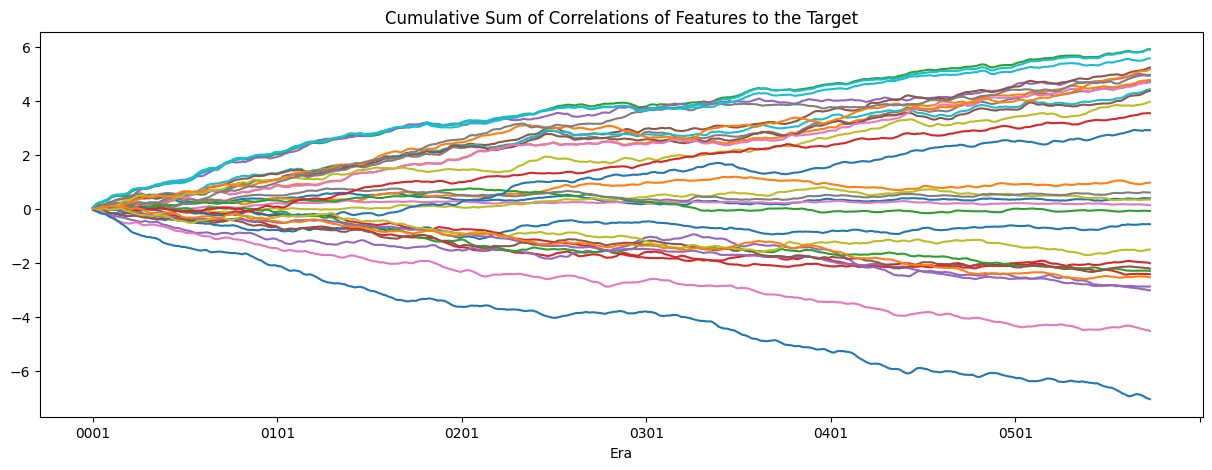

In [8]:
# Plot the cumulative sum of the per-era correlations of the features
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target", legend=False, xlabel="Era")

Features with consistent negative correlations are just as good as ones with positive correlations since the sign is arbitrary. Before further analysis, lets flip the sign of correlations for the features with negative average correlations

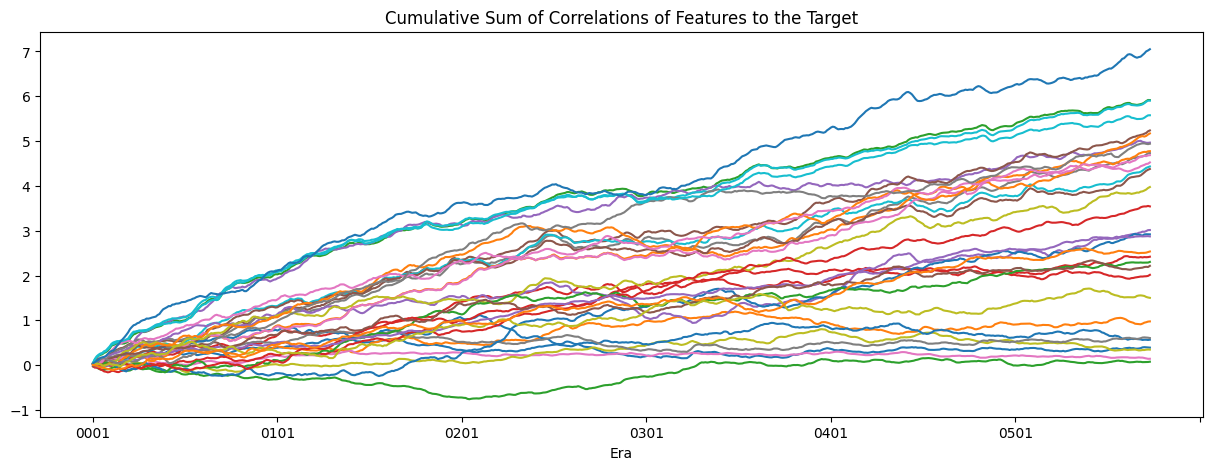

In [9]:
per_era_corrs *= np.sign(per_era_corrs.mean())
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target", legend=False, xlabel="Era")

## Feature Risk Summary Metrics

Now that we have performance data for each of our features, lets look at summary metrics 

In [114]:
def metrics(per_era_corr):
    corr_mean = per_era_corr.mean()
    corr_std = per_era_corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

    eras = training_data.era.unique()
    corr_mean_first_half = per_era_corr.loc[eras[:len(eras)//2]].mean()
    corr_mean_second_half = per_era_corr.loc[eras[len(eras)//2:]].mean()
    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return { "mean": corr_mean, "std": corr_std, "sharpe": corr_sharpe, "max_drawdown": max_drawdown, "delta": delta }

# compute performance metrics for each feature
feature_metrics = pd.DataFrame(index=feature_cols, columns=["mean", "std", "sharpe", "max_drawdown", "delta"])
for feature_name in feature_cols:
    feature_metrics.loc[feature_name] = metrics(per_era_corrs[feature_name])

# make all cells numeric 
feature_metrics = feature_metrics.apply(pd.to_numeric)

feature_metrics.sort_values("mean", ascending=False)

,mean,std,sharpe,max_drawdown,delta
feature_unswaddled_inenarrable_goody,0.012282,0.019340,0.635063,-0.252688,0.001813
feature_coraciiform_sciurine_reef,0.010305,0.015693,0.656670,-0.164262,0.006789
feature_piping_geotactic_cusp,0.010284,0.015753,0.652796,-0.179569,0.005983
feature_unsizable_ancestral_collocutor,0.009715,0.015981,0.607901,-0.204947,0.007183
feature_distressed_bloated_disquietude,0.009124,0.018104,0.503994,-0.268530,0.001863
feature_sodding_choosy_eruption,0.009009,0.018243,0.493818,-0.515897,0.002571
feature_cyclopedic_maestoso_daguerreotypist,0.008652,0.018057,0.479125,-0.187818,0.008906
feature_unpainted_censual_pinacoid,0.008607,0.016073,0.535502,-0.208227,0.006267
feature_fribble_gusseted_stickjaw,0.008319,0.016708,0.497914,-0.200807,0.000165
feature_elaborate_intimate_bor,0.008247,0.018632,0.442644,-0.306579,0.002554


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'std'}>,
        <AxesSubplot:title={'center':'sharpe'}>],
       [<AxesSubplot:title={'center':'max_drawdown'}>,
        <AxesSubplot:title={'center':'delta'}>, <AxesSubplot:>]],
      dtype=object)

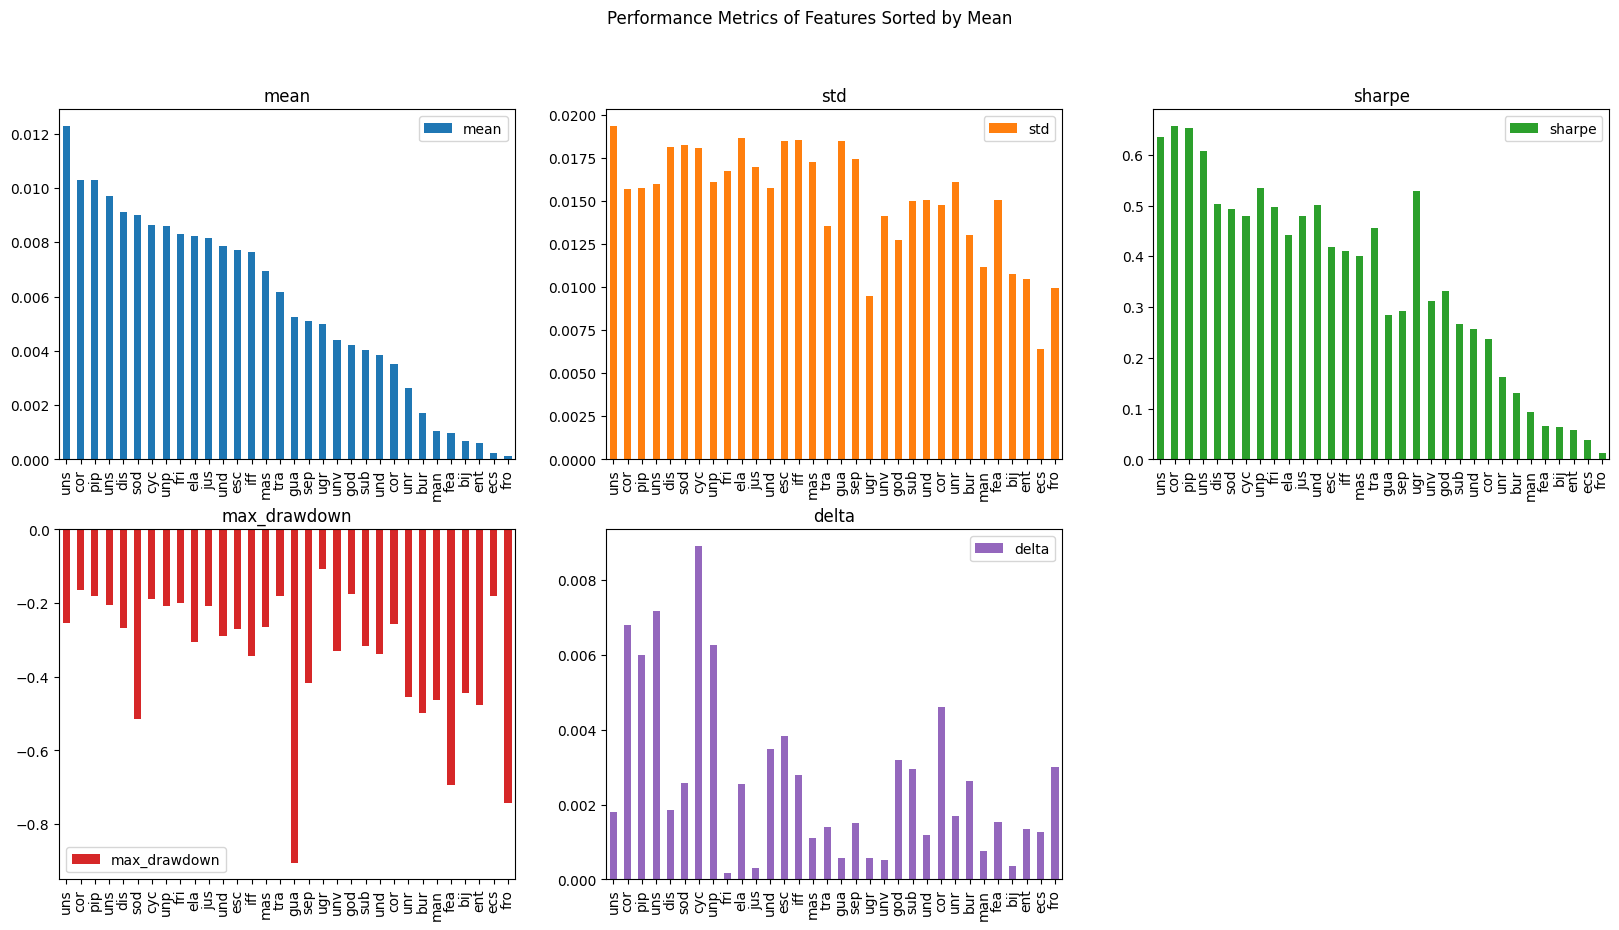

In [11]:
# make a copy of the feature metrics 
feature_metrics_copy = feature_metrics.copy()

# shorten the feature names by removing the prefix and taking the first 3 characters
feature_metrics_copy.index = feature_metrics_copy.index.str.replace("feature_", "")
feature_metrics_copy.index = feature_metrics_copy.index.str[:3]

# plot the performance metrics of the features as bar charts sorted by mean
feature_metrics_copy.sort_values("mean", ascending=False).plot.bar(
    subplots=True, figsize=(20, 10), layout=(2, 3), sharex=False, title="Performance Metrics of Features Sorted by Mean"
)

The bar charts above show the performance metrics of each feature in the training data computed
- `mean` mean of per era correlations
- `std` standard deviation of per era correlations
- `sharpe` standard deviation adjusted mean of per era correlations
- `max_drawdown` maximum peak to trough drop in cumulative per era correlation 
- `delta` the absolute delta between the first and second half of eras

The most obvious observation is that `mean`, and `sharpe` seem to tell the same story - features with the highest sharpe also have the highest mean, features with the lowest mean tend to have the lowest sharpe. This should be intuitive given how these metrics are computed.

But just because a feature has a high `mean` or `sharpe` does not neccesarily mean it will continue to perform well in new eras. When talking about feature risk, it may be more helpful to consider `std` and `delta`.

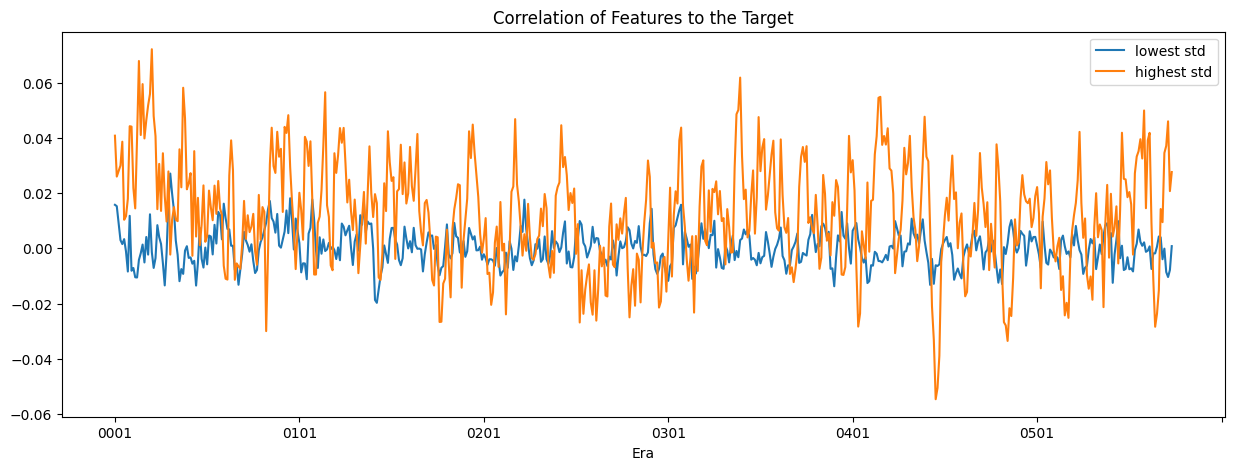

In [12]:
import matplotlib.pyplot as plt
# plot the per era correlation of the feature with highest and lowest std
per_era_corrs[[feature_metrics["std"].idxmin(), feature_metrics["std"].idxmax()]].plot(
    figsize=(15, 5), title="Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest std", "highest std"])

Above is a comparison of the highest and lowest `std` features. Which one looks more risky to you and why?

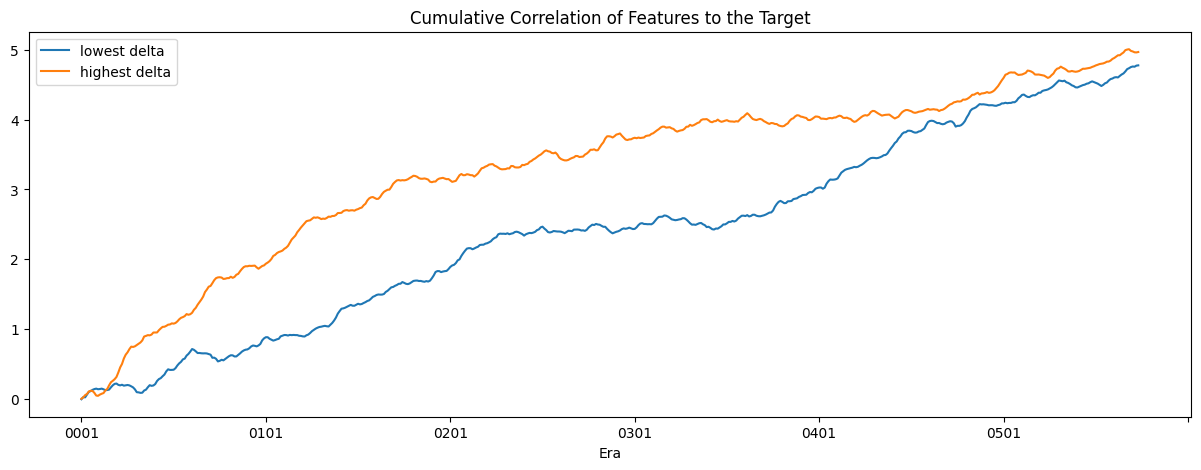

In [13]:
# plot the per era correlation of the feature with the lowest delta
per_era_corrs[[feature_metrics["delta"].idxmin(), feature_metrics["delta"].idxmax()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
) 

plt.legend(["lowest delta", "highest delta"]);

Above is a comparison of the highest and lowest `delta` features. Another way to describe these two features, instead of "lowest delta" and "highest delta" would be "most stable" and "least stable". Which one looks more risky to you and why?

# 2. Measuring Feature Exposure

`Feature exposure` is a measure of a model's exposure to feature risk. 

One simple measure of feature exposure is the Pearson correlation between a model's predictions and each feature. 

Let's train a model, make some predictions on the validation set, and measure its feature exposure.

In [14]:
import lightgbm as lgb

try: 
  model = lgb.Booster(model_file='small_lgb.model')
except lgb.basic.LightGBMError:
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
  )
  model.fit(
    training_data[feature_cols],
    training_data["target"]
  )
  model.booster_.save_model("small_lgb.model")

[LightGBM] [Fatal] Could not open small_lgb.model


In [105]:
# Download validation data 
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Generate predictions against the out of sample validation features
# This will take about 2 minutes 🍵
validation_data["prediction"] = model.predict(validation_data[feature_cols])

2023-07-24 14:27:04,943 INFO numerapi.utils: target file already exists
2023-07-24 14:27:04,943 INFO numerapi.utils: download complete


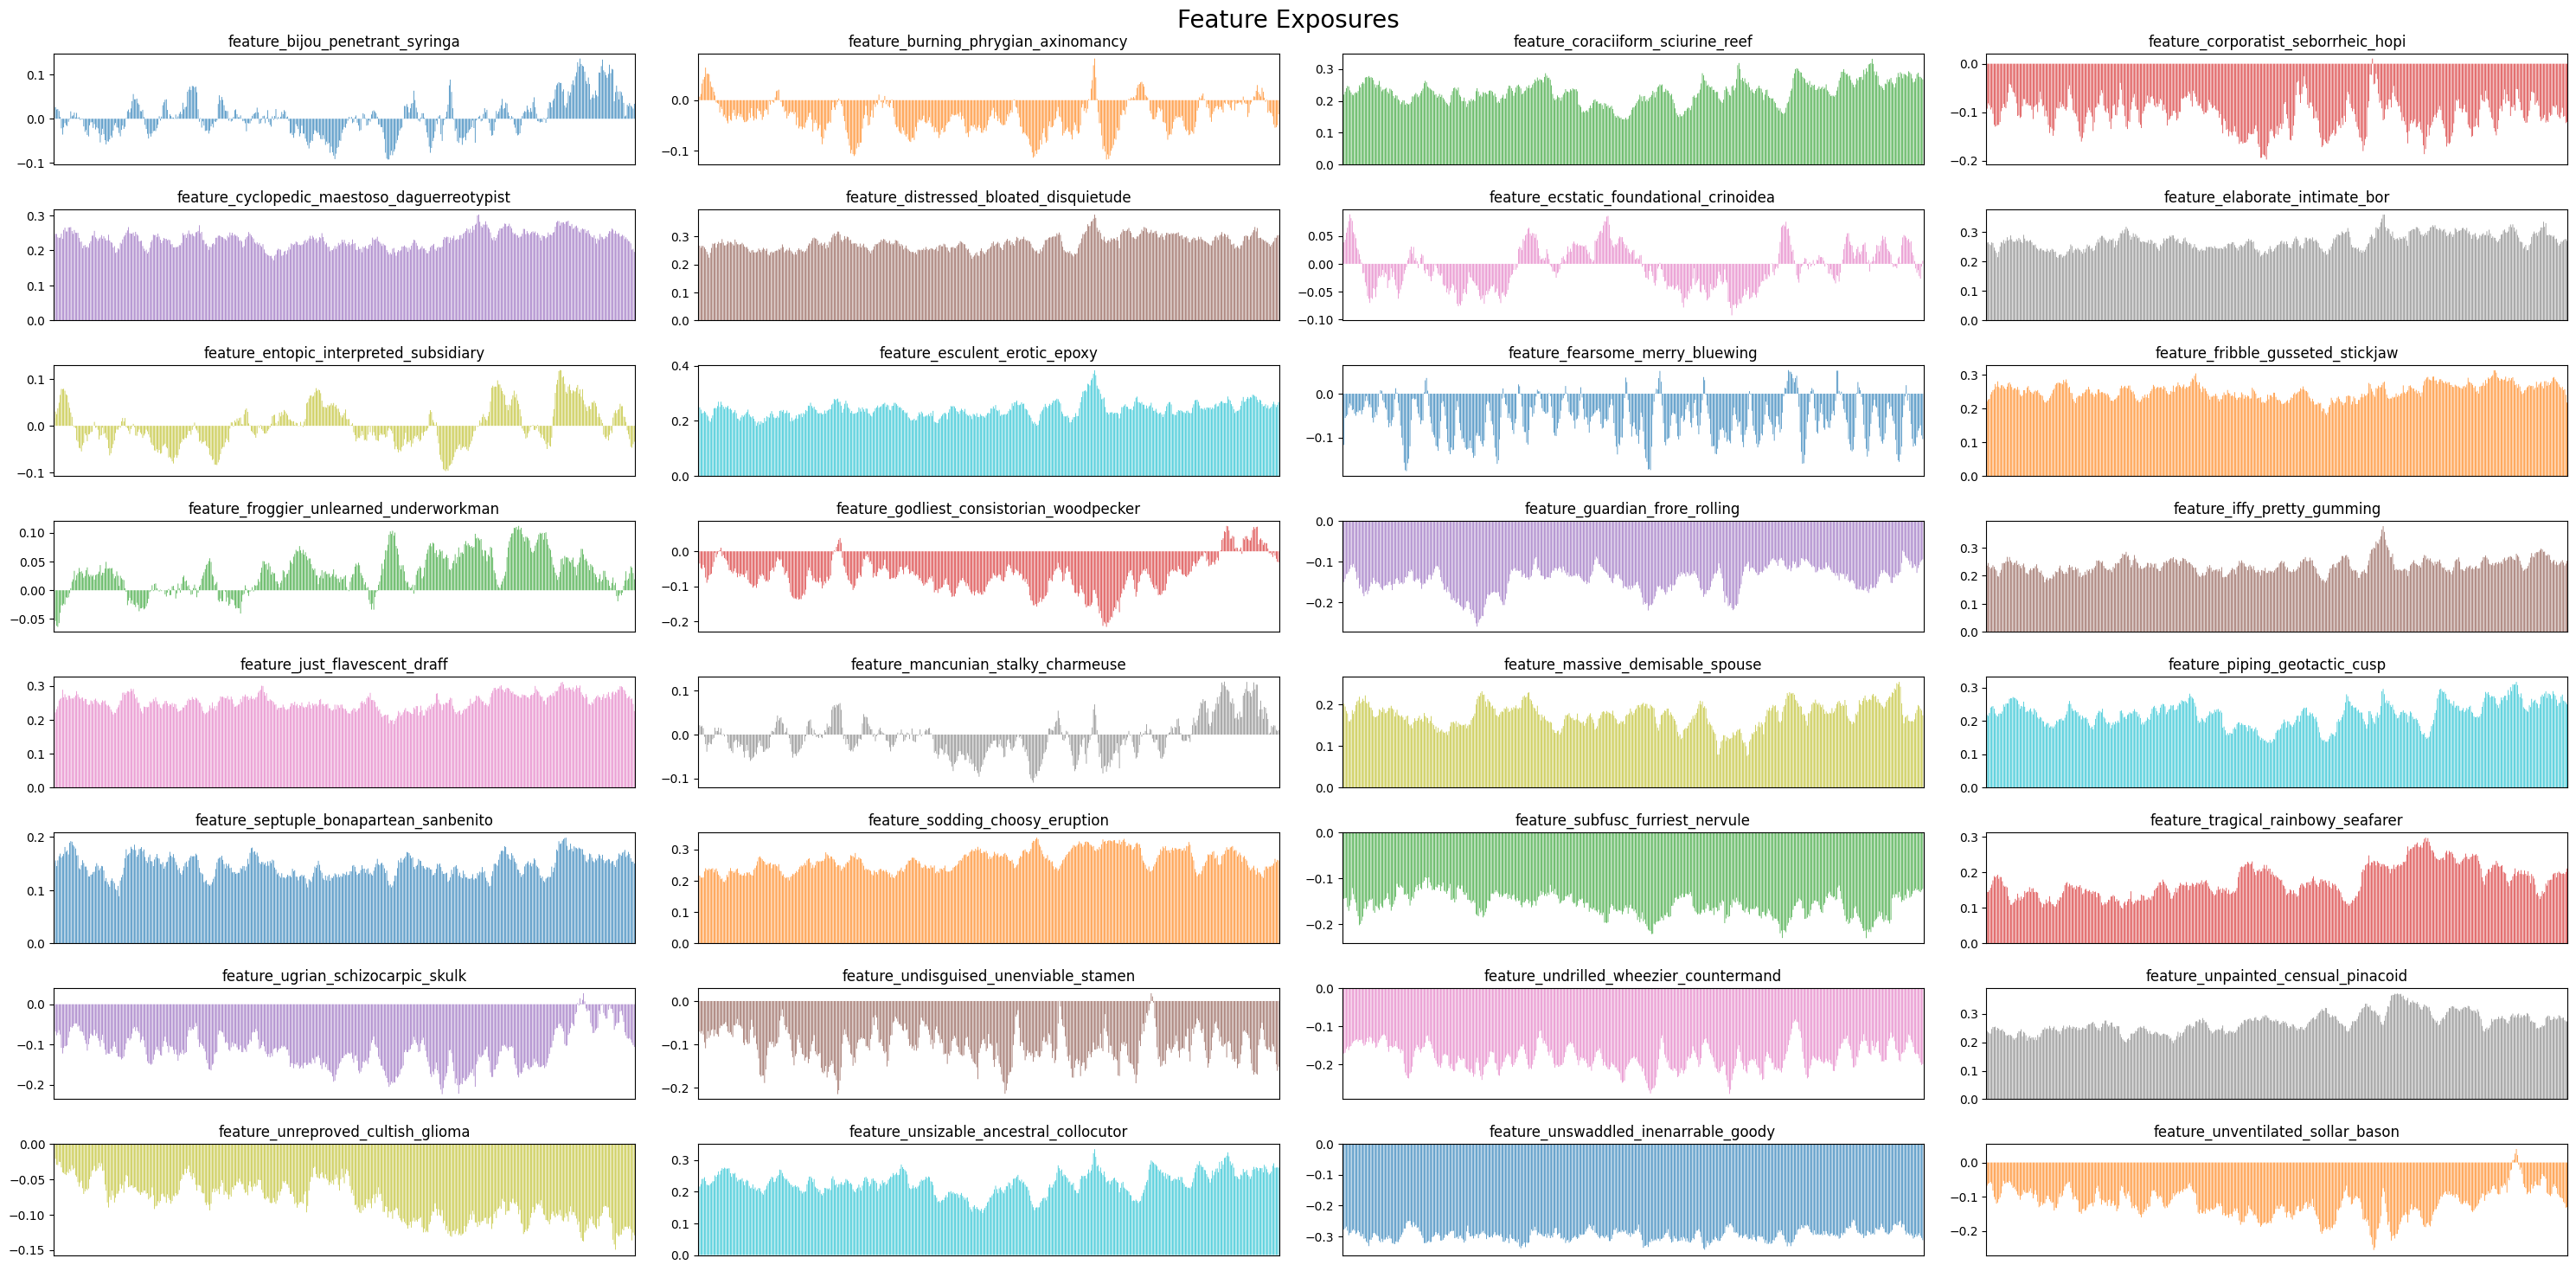

In [40]:
# compute the pearson correlation of the predictions with each feature
feature_exposures = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]))

# plot the feature exposures as bar charts 
feature_exposures.plot.bar(
    subplots=True, figsize=(30, 15), layout=(8, 4), sharex=False, title="Feature Exposures", xticks=[], legend=False, snap=False
)
# remove title for each chart
for ax in plt.gcf().axes:
    ax.set_xlabel("")
# reduce padding between title and charts 
plt.tight_layout(pad=1.5)
# increase font size of main title 
plt.gcf().suptitle("Feature Exposures", fontsize=20);

Our model seems to be consistently positively or negative correlated to some features. But what will happen to our model's performance if these features suddenly reverse or stop working out of sample?

Another, perhaps more useful way to visualize the overall feature exposure of our model is to look at the per-era max feature exposure across all features. This is a simple way for us to estimate the maximum feature risk we are exposed to across all features.

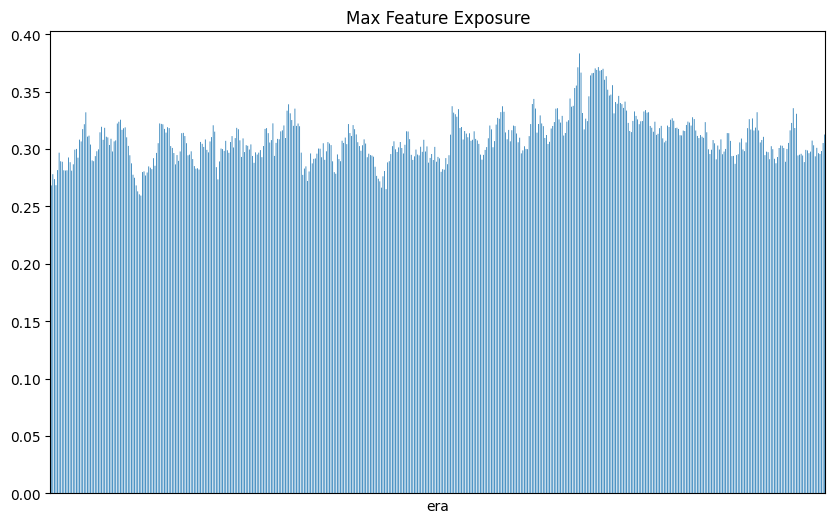

In [41]:
# Plot the max feature exposure per era
max_feature_exposure_per_era = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]).abs().max())
max_feature_exposure_per_era.plot(title="Max Feature Exposure", kind="bar", figsize=(10, 6), xticks=[], snap=False);

In [42]:
# Mean max feature exposure across eras
max_feature_exposure_mean = max_feature_exposure_per_era.mean()
max_feature_exposure_mean

0.3084463356342113

## 3. Feature Neutralization

`Feature Neutralization` is a way to reduce `Feature Exposure`. 

In [86]:
def neutralize(predictions: pd.DataFrame, features: pd.DataFrame, proportion: float = 1.0) -> pd.DataFrame:
    # add a constant term the features so we can fit the bias/offset term
    features = np.hstack((features, np.array([np.mean(predictions)] * len(features)).reshape(-1, 1)))
    # remove the parts of the predictions that are linearly correlated with features
    return predictions - proportion * features @ (np.linalg.pinv(features, rcond=1e-6) @ predictions)

In [67]:
blah = neutralized_preds.reset_index().set_index('id')
blah

,era,0
id,,
n000101811a8a843,0575,0.385595
n001e1318d5072ac,0575,0.361052
n002a9c5ab785cbb,0575,0.393617
n002ccf6d0e8c5ad,0575,0.396385
n0051ab821295c29,0575,0.369895
...,...,...
nffd5c02c7a57ee7,1067,0.380723
nffddfb386ab0c50,1067,0.361601
nffe908e0138f7bc,1067,0.366404


In [91]:
neutralized.reset_index()

,era,id,prediction
0,0575,n000101811a8a843,0.364025
1,0575,n001e1318d5072ac,0.370351
2,0575,n002a9c5ab785cbb,0.380195
3,0575,n002ccf6d0e8c5ad,0.382413
4,0575,n0051ab821295c29,0.364377
...,...,...,...
2516795,1067,nffd5c02c7a57ee7,0.367746
2516796,1067,nffddfb386ab0c50,0.354267
2516797,1067,nffe908e0138f7bc,0.380230
2516798,1067,nfff0dece2c4bd04,0.381860



Let's try to neutralize our predictions to the features at different porportions and see how that affects the performance of our model.

In [106]:
# Neutralize predictions per-era againat all features at different proportions
proportions = [0.25, 0.5, 0.75, 1.0]
for proportion in proportions:
    # neutralized_preds = neutralize(validation_data["prediction"], validation_data[feature_cols], proportion=proportion)
    neutralized = validation_data.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_cols], proportion=proportion))
    validation_data[f"neutralized_{proportion*100:.0f}"] = neutralized.reset_index().set_index("id")['prediction']


# Rename original predictions to "neutralized_0" for easier comparison
validation_data.rename(columns={"prediction": "neutralized_0"})

# Align the neutralized predictions with the validation data
prediction_cols = [f for f in validation_data.columns if "neutralized" in f]
validation_data[["era"] + prediction_cols + ["target"]]

,era,neutralized_25,neutralized_50,neutralized_75,neutralized_100,target
id,,,,,,
n000101811a8a843,0575,0.364025,0.239208,0.114391,-0.010426,0.750000
n001e1318d5072ac,0575,0.370351,0.245291,0.120230,-0.004830,0.000000
n002a9c5ab785cbb,0575,0.380195,0.257994,0.135793,0.013592,0.500000
n002ccf6d0e8c5ad,0575,0.382413,0.257167,0.131922,0.006676,0.000000
n0051ab821295c29,0575,0.364377,0.242076,0.119776,-0.002525,0.500000
...,...,...,...,...,...,...
nffd5c02c7a57ee7,1067,0.367746,0.245576,0.123405,0.001234,0.250000
nffddfb386ab0c50,1067,0.354267,0.233187,0.112108,-0.008971,0.500000
nffe908e0138f7bc,1067,0.380230,0.252847,0.125464,-0.001919,0.500000


In [93]:
# Compute max feature exposure for each set of predictions in each era
max_feature_exposures = {}
for col in prediction_cols:
    max_feature_exposures[col] = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d[col]).abs().max())

<AxesSubplot:title={'center':'Max Feature Exposures'}, xlabel='era'>

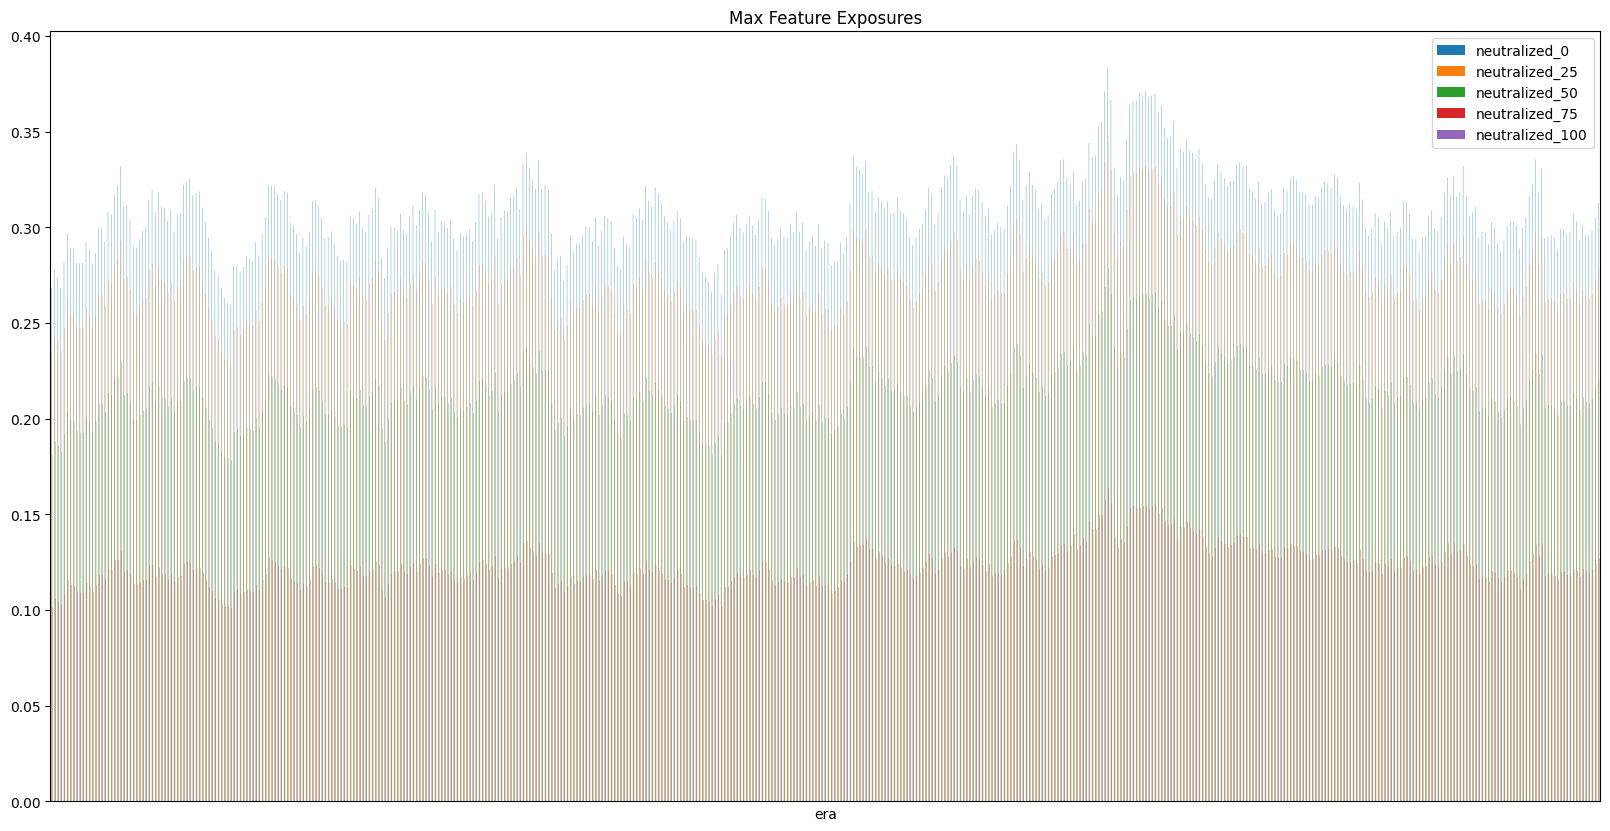

In [94]:
max_feature_exposures = pd.DataFrame(max_feature_exposures)
# move neutralized_0 to the front
max_feature_exposures = max_feature_exposures[["neutralized_0"] + [c for c in max_feature_exposures.columns if c != "neutralized_0"]]
# plot 
max_feature_exposures.plot.bar(figsize=(20, 10), title="Max Feature Exposures", xticks=[], snap=False)

Great! Looks like we have succesfully reduced our max feature exposure from all the way down to 0. Now let's check the other performance metrics before vs after neutralization.

<AxesSubplot:title={'center':'Cumulative Correlation of Neutralized Predictions'}, xlabel='era'>

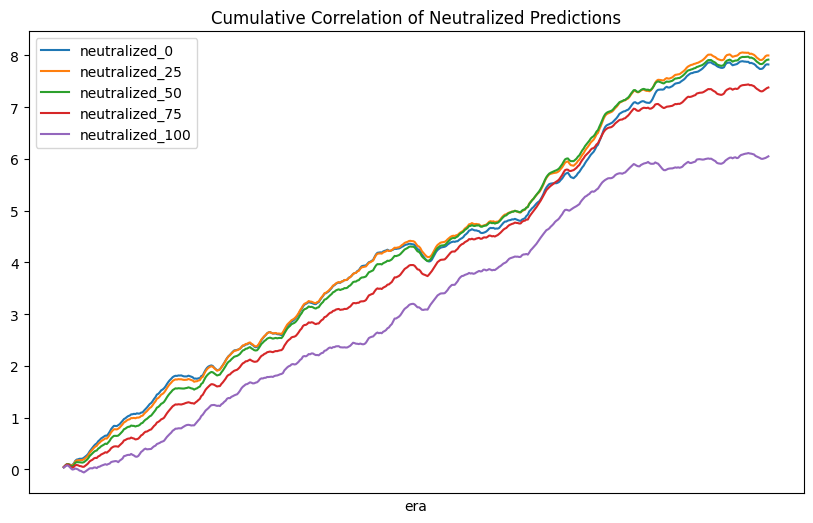

In [95]:
# Plot cumulative correlations
correlations = {}
cumulative_correlations = {}
for col in prediction_cols:
    correlations[col] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

pd.DataFrame(cumulative_correlations).plot(title="Cumulative Correlation of Neutralized Predictions", figsize=(10, 6), xticks=[])

In [96]:
summary_metrics = {}
for col in prediction_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    max_feature_exposure_mean = max_feature_exposures[col].mean()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
        "max_feature_exposure_mean": max_feature_exposure_mean
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics).T

,mean,std,sharpe,max_drawdown,max_feature_exposure_mean
neutralized_0,0.015869,0.021357,0.743044,0.342537,0.308446
neutralized_25,0.016223,0.020702,0.783654,0.314493,0.273282
neutralized_50,0.016060,0.019708,0.814878,0.282033,0.215141
neutralized_75,0.014967,0.018438,0.811766,0.213556,0.123164
neutralized_100,0.012269,0.017486,0.701657,0.159665,0.000000


As expected, `max feature exposure mean` and `std` go down as we increase neutralization. More interestingly, `sharpe` peaks at 50% while `mean` peaks at 20%. 

Based on these numbers, it seems like neutralizing at 50% strikes a good balance between safety and performance.

# 4. Deploying a model with feature neutralization

Now that we've determined we want to neutralize at 50%, how do we deploy a model that neutralizes against live feature data every round? Model Uploads makes this easy, first we define our prediction function (`predict_neutral`) that calls our `neutralize` function. After a quick test, we simply pass the `predict_neutralize` function to 

In [97]:
def predict_neutral(live_features: pd.DataFrame) -> pd.DataFrame:
    predictions = pd.Series(model.predict(live_features[feature_cols]), index=live_features.index) 
    # neutralize to features by 50%
    neutralized = neutralize(predictions, live_features[feature_cols], 0.5)
    submission = pd.Series(neutralized).rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [98]:
# Quick test on live features
current_round_number = napi.get_current_round()
napi.download_dataset("v4/live.parquet", f"v4/live_{current_round_number}.parquet")
live_features = pd.read_parquet(f"v4/live_{current_round_number}.parquet", columns=feature_cols)
predict_neutral(live_features)

2023-07-24 14:15:47,611 INFO numerapi.utils: target file already exists
2023-07-24 14:15:47,615 INFO numerapi.utils: download complete


,prediction
id,
n000d1cadcdbc70f,0.216670
n00161cf81163408,0.250253
n001fc47b967f438,0.239328
n00238c33a9ac757,0.037831
n003b6d0565b7b59,0.642322
...,...
nff9694d7c110513,0.557152
nffa11825d8ce071,0.837346
nffa4d6e827c1ebb,0.006069


In [22]:
# Use the cloudpickle library to serialize your predict_neutral function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("predict_neutral.pkl", "wb") as f:
    f.write(p)

In [113]:
def get_riskiest_features(feature_metrics: pd.DataFrame, n=8) -> list[str]:
    # TODO: implement this function
    top_n_delta = feature_metrics.sort_values("delta", ascending=False)[:n] 
    print(top_n_delta)
    return top_n_delta.index.to_list()

get_riskiest_features(feature_metrics)

                                                mean      std   sharpe  \
feature_cyclopedic_maestoso_daguerreotypist 0.008652 0.018057 0.479125   
feature_unsizable_ancestral_collocutor      0.009715 0.015981 0.607901   
feature_coraciiform_sciurine_reef           0.010305 0.015693 0.656670   
feature_unpainted_censual_pinacoid          0.008607 0.016073 0.535502   
feature_piping_geotactic_cusp               0.010284 0.015753 0.652796   
feature_corporatist_seborrheic_hopi         0.003510 0.014770 0.237647   
feature_esculent_erotic_epoxy               0.007724 0.018446 0.418737   
feature_undrilled_wheezier_countermand      0.007881 0.015734 0.500852   

                                             max_drawdown    delta  
feature_cyclopedic_maestoso_daguerreotypist     -0.187818 0.008906  
feature_unsizable_ancestral_collocutor          -0.204947 0.007183  
feature_coraciiform_sciurine_reef               -0.164262 0.006789  
feature_unpainted_censual_pinacoid              -0.208227

['feature_cyclopedic_maestoso_daguerreotypist',
 'feature_unsizable_ancestral_collocutor',
 'feature_coraciiform_sciurine_reef',
 'feature_unpainted_censual_pinacoid',
 'feature_piping_geotactic_cusp',
 'feature_corporatist_seborrheic_hopi',
 'feature_esculent_erotic_epoxy',
 'feature_undrilled_wheezier_countermand']

# 5. Improving feature neutralization 

We've shown how neutralizing ALL features by 50% can improve our out-of-sample performance, but is there a more selective approach that would lead to better performance on validation data? We saw that over-neutralizing everything led to worse performance, let's try neutralizing to a subset of the 8 "riskiest" features.

We leave this as an exercise to the user: 
1. How do we determine our top N riskiest features? (Hint: think back to previous `delta` and `std` plots)

<AxesSubplot:title={'center':'Cumulative Correlation of Neutralized Predictions'}, xlabel='era'>

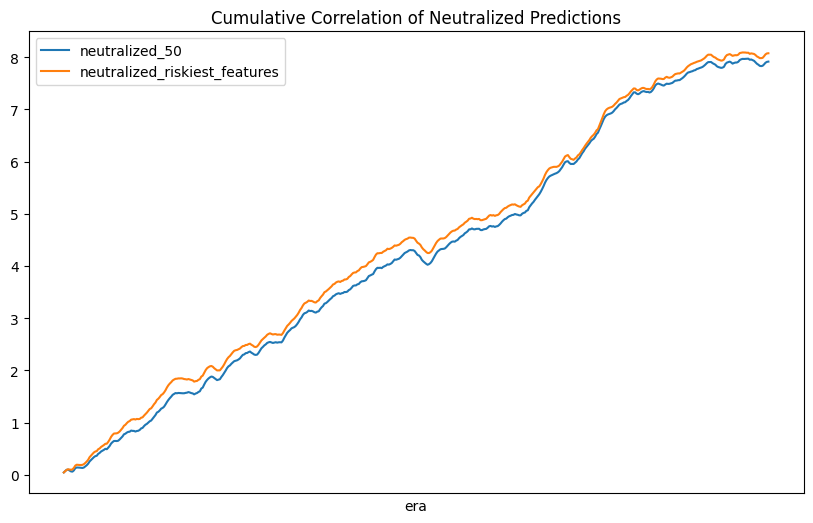

In [121]:
# TODO: do you get better perf when neutralizing to top std features vs top delta features?
def get_riskiest_features(feature_metrics: pd.DataFrame, n=8) -> list[str]:
    # TODO: implement this function
    top_n_delta = feature_metrics.sort_values("delta", ascending=False)[:n] 
    return top_n_delta.index.to_list()

risky_feature_cols = get_riskiest_features(feature_metrics.sort_values("mean", ascending=False), n=8)

# get predictions neutralizing to only risky features
neutralized = validation_data.groupby("era").apply(lambda d: neutralize(d["prediction"], d[risky_feature_cols], proportion=0.5))
validation_data[f"neutralized_riskiest_features"] = neutralized.reset_index().set_index("id")['prediction']

# Plot cumulative correlations
correlations = {}
cumulative_correlations = {}
prediction_cols = ['neutralized_50', 'neutralized_riskiest_features']
for col in prediction_cols:
    correlations[col] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

pd.DataFrame(cumulative_correlations).plot(title="Cumulative Correlation of Neutralized Predictions", figsize=(10, 6), xticks=[])

In [122]:
summary_metrics = {}
for col in prediction_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics).T

,mean,std,sharpe,max_drawdown
neutralized_50,0.016060,0.019708,0.814878,0.282033
neutralized_riskiest_features,0.016384,0.020315,0.806490,0.296747


And now to deploy our model with the improved feature neutralization, the simplest way is to hardcode the list riskiest features. Cloudpickle detects that our function depends on this externally defined list and will include it with the serialized model.

# TODO: better way than hardcoding the features?

In [ ]:
def predict_neutral(live_features: pd.DataFrame) -> pd.DataFrame:
    predictions = pd.Series(model.predict(live_features[feature_cols]), index=live_features.index) 
    # neutralize to riskiest features
    
    neutralized_risky_features = neutralize(predictions, live_features[feature_cols], 0.5)
    neutralized = pass
    submission = pd.Series(neutralized).rank(pct=True, method="first")
    return submission.to_frame("prediction")

In your research, you may want to experiment with neutralizing different features at different porportions and make your own judgement on how to balance the risk reward benefits of neutralization. If you want to learn more, including the math behind the neutralization function, we highly encourage you to read up on the following posts: 
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

In [24]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_neutral.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model prediction pipeline! 

# TODO: show comparison with a model that is regularized and show how much better feature neutralization is..